In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [2]:
root_directory = 'G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/'

patch_size = 320
image_dataset = []

In [3]:
for path, subdirs, files in os.walk(root_directory,topdown=True):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    images = os.listdir(path)

G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Chipping Wear
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Chipping Wear
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Chipping Wear\Images
Images
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Chipping Wear\Masks
Masks
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Crater Wear
G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Crater Wear
G:/Other computers/M

In [4]:
print(path)

G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Flank Wear\Masks


In [5]:
path.split(os.path.sep)

['G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/U_Net_Tool_Wear_Black_White/Dataset/Flank Wear',
 'Masks']

In [6]:
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'Images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                #image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)               

In [7]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'Masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".jpg"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)

In [8]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [9]:
image_dataset.shape

(108, 320, 320, 3)

In [10]:
mask_dataset.shape

(108, 320, 320, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


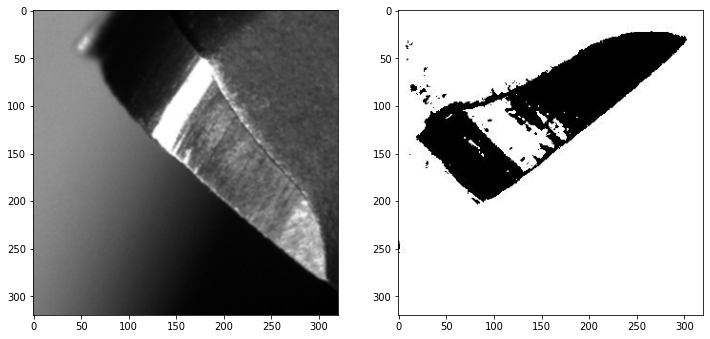

In [11]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [12]:
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)

WOtool = '#FFFFFF'.lstrip('#') #68,0,83
WOtool= np.array(tuple(int(WOtool[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Tool_Wear = '#000000'.lstrip('#') 
Tool_Wear = np.array(tuple(int(Tool_Wear[i:i+2], 16) for i in (0, 2, 4))) #253,230,36
label = single_patch_mask

60


In [13]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == WOtool,axis=-1)] = 0
    label_seg [np.all(label == Tool_Wear,axis=-1)] = 1  
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [14]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [15]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


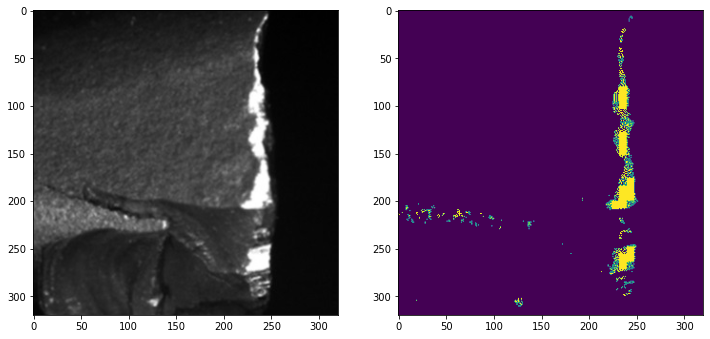

In [16]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [17]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 16)

In [18]:
weights = [0.2, 0.8]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [19]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  

In [20]:
metrics=['accuracy', jacard_coef]

In [21]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 320, 320, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 160, 160, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 160, 160, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 320, 320, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [22]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=30, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/30
22/22 [==============================] - 48s 2s/step - loss: 0.8840 - accuracy: 0.6097 - jacard_coef: 0.3316 - val_loss: 0.8911 - val_accuracy: 0.6790 - val_jacard_coef: 0.3419
Epoch 2/30
22/22 [==============================] - 44s 2s/step - loss: 0.8673 - accuracy: 0.7432 - jacard_coef: 0.3908 - val_loss: 0.8523 - val_accuracy: 0.7083 - val_jacard_coef: 0.4996
Epoch 3/30
22/22 [==============================] - 43s 2s/step - loss: 0.8206 - accuracy: 0.8454 - jacard_coef: 0.6573 - val_loss: 0.7863 - val_accuracy: 0.8911 - val_jacard_coef: 0.7734
Epoch 4/30
22/22 [==============================] - 43s 2s/step - loss: 0.8038 - accuracy: 0.8703 - jacard_coef: 0.7376 - val_loss: 0.7866 - val_accuracy: 0.8936 - val_jacard_coef: 0.7765
Epoch 5/30
22/22 [==============================] - 43s 2s/step - loss: 0.7979 - accuracy: 0.8771 - jacard_coef: 0.7530 - val_loss: 0.7921 - val_accuracy: 0.8748 - val_jacard_coef: 0.7410
Epoch 6/30
22/22 [==============================] - 42s 2s/s

In [23]:
from tensorflow.keras.models import load_model
model.save('Insert_3_30epochs.hdf5')

In [24]:
from tensorflow.keras.models import load_model
my_model = load_model('Insert_3_30epochs.hdf5', 
                      compile=False)

In [25]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 2s 2s/step
Mean IoU = 0.5782016


In [26]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 114ms/step


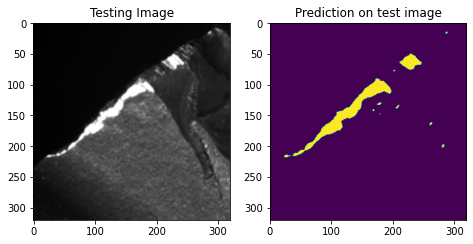

In [27]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth)
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

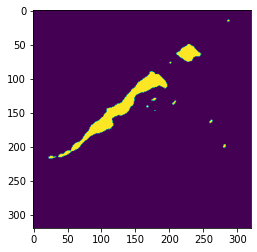

In [28]:
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.imshow(predicted_img)

In [29]:
plt.imsave("ouput-9.jpg",predicted_img,cmap='binary')

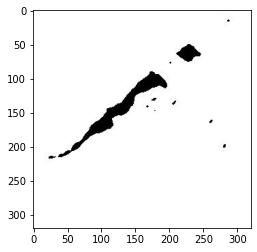

In [30]:
img = cv2.imread('G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/ouput-9.jpg')
plt.imshow(img,cmap='binary')

In [31]:
# reading the image data from desired directory 
img = cv2.imread("G:/Other computers/My_Laptop/Objective_1/Semantic Segmentation - U - Net/ouput-9.jpg") 
cv2.imshow('Image',img) 
  
# counting the number of pixels 
number_of_white_pix = np.sum(img == 255) 
number_of_black_pix = np.sum(img == 0) 
worn_pix = np.sum(img <= 40)  
unworn_pix = np.sum(img >= 210)

print('Number of white pixels:', number_of_white_pix) 
print('Number of black pixels:', number_of_black_pix)
print('Number of worn pixels:', worn_pix)
print('Number of unworn pixels:', unworn_pix)

Number of white pixels: 291762
Number of black pixels: 6534
Number of worn pixels: 9876
Number of unworn pixels: 297324


In [32]:
Worn_Pixels= (worn_pix/3) # since the information is extracted for 3 rgb layers (divide it by 3 to obtain the actual tool wear)
print('No_of_Worn_Pixels:',Worn_Pixels)

UnWorn_Pixels= (unworn_pix/3)
print('No_of_UnWorn_Pixels:',UnWorn_Pixels)

No_of_Worn_Pixels: 3292.0
No_of_UnWorn_Pixels: 99108.0


In [33]:
Worn_Percentage= (Worn_Pixels/(320*320))
Total_Area_Image= ((320*320*8*8)/(1000*1000))
Tool_Wear_Area= ((320*320*8*8)/(1000*1000))*(Worn_Pixels/(320*320))

print('Worn_Percentage (%):',Worn_Percentage)
print('Total_Area_Image (mm^2):',Total_Area_Image)
print('Tool_Wear_Area (mm^2):',Tool_Wear_Area)

Worn_Percentage (%): 0.0321484375
Total_Area_Image (mm^2): 6.5536
Tool_Wear_Area (mm^2): 0.21068800000000001
